In [2]:
import os, time
import numpy as np
import random
random.seed(42)
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, classification_report

import torch
torch.manual_seed(42)
from torch import nn
from torch.optim import SGD, Adam
from torch.utils.data import DataLoader, RandomSampler
from torch.utils.data.dataset import Dataset
from torchvision.models import resnet
from torchvision import transforms, datasets, models
from torch.optim.lr_scheduler import ReduceLROnPlateau

print('PyTorch %s %s' % (torch.__version__, torch.cuda.get_device_properties(0) if torch.cuda.is_available() else 'CPU'))
#from torch_lr_finder import LRFinder, TrainDataLoaderIter, ValDataLoaderIter

PyTorch 1.5.1+cu101 _CudaDeviceProperties(name='Tesla T4', major=7, minor=5, total_memory=15079MB, multi_processor_count=40)


In [3]:
from google.colab import files, drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [4]:
def load_transform_images(images_path, presplit, train_split, test_split, val_split, batch_size, threads, mean, std):
    train_transform = transforms.Compose([
                                         transforms.Resize((256,256)),
                                         transforms.RandomRotation(degrees=15),
                                         #transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
                                         transforms.CenterCrop((224,224)),
                                         transforms.RandomHorizontalFlip(),
                                         transforms.ToTensor(),
                                         transforms.Normalize(torch.Tensor(mean),
                                                              torch.Tensor(std))])

    test_transform = transforms.Compose([
                                        transforms.Resize((224,224)),
                                        #transforms.CenterCrop((224,224)),
                                        transforms.ToTensor(),
                                        transforms.Normalize(torch.Tensor(mean),
                                                             torch.Tensor(std))])

    val_transform = transforms.Compose([
                                       transforms.Resize((224,224)),
                                       #transforms.CenterCrop((224,224)),
                                       transforms.ToTensor(),
                                       transforms.Normalize(torch.Tensor(mean),
                                                            torch.Tensor(std))])

    if presplit:
        try:
            training_set = datasets.ImageFolder(root=images_path+'/train', transform=train_transform)
            validation_set = datasets.ImageFolder(root=images_path+'/val', transform=val_transform)
        except FileNotFoundError:
            raise Exception('Not presplit into Training and Validation sets')
        try:
            testing_set = datasets.ImageFolder(root=images_path+'/test', transform=test_transform)
        except:
            testing_set = validation_set
        dataset = training_set
    else:
        dataset = datasets.ImageFolder(root=images_path, transform=train_transform)
        train_size = int(train_split * len(dataset))
        test_size = int(test_split * len(dataset))
        val_size = len(dataset) - train_size - test_size
        training_set, testing_set, validation_set = torch.utils.data.random_split(dataset, [train_size, test_size, val_size])
    
    training_set_loader = DataLoader(training_set, batch_size=batch_size, num_workers=threads, shuffle=True)
    validation_set_loader = DataLoader(validation_set, batch_size=batch_size, num_workers=threads, shuffle=True)
    testing_set_loader = DataLoader(testing_set, batch_size=batch_size, num_workers=threads, shuffle=False)

    return training_set_loader, testing_set_loader, validation_set_loader, dataset, training_set, testing_set, validation_set

def load_network(net_model, net_name, dropout_ratio, class_names, unfrozen_layers):
    for name, child in net_model.named_children():
        if name in unfrozen_layers:
            print(name + ' is unfrozen')
            for param in child.parameters():
                param.requires_grad = True
        else:
            print(name + ' is frozen')
            for param in child.parameters():
                param.requires_grad = False
    
    if net_name.startswith('resnet'):
        num_ftrs = net_model.fc.in_features
        net_model.fc = nn.Sequential(nn.Linear(num_ftrs, 256),
                                     nn.ReLU(),
                                     nn.Dropout(p=dropout_ratio),
                                     nn.Linear(256, len(class_names)))

    elif net_name.startswith('vgg'):
        num_ftrs = net_model.classifier[6].in_features
        net_model.classifier[6] = nn.Sequential(nn.Linear(num_ftrs, 256),
                                                nn.ReLU(),
                                                nn.Dropout(p=dropout_ratio),
                                                nn.Linear(256, len(class_names)))
    display(net_model)
    
    total_params = sum(param.numel() for param in net_model.parameters())
    print(f'{total_params:,} total parameters')

    total_trainable_params = sum(param.numel() for param in net_model.parameters() if param.requires_grad)
    print(f'{total_trainable_params:,} training parameters')
    
    return net_model

In [5]:
def plot_images_per_class(images_path, mode, title):
    data_folder = images_path+'/'+mode+'/'
    item_dict = {root.split('/')[-1]: len(files) for root, _, files in os.walk(data_folder)}
   
    plt.figure(figsize=(20,8))
    plt.bar(list(item_dict.keys())[1:], list(item_dict.values())[1:], color='g')
    plt.title(title)
    plt.xticks(rotation=90)
    plt.xlabel('Class')
    plt.ylabel('Number of Images')
    plt.show()

def plot_grid_images(training_set, batch_size, class_names, mean, std, rows=3, columns=3, size=14):
    sampler = RandomSampler(training_set, num_samples=batch_size, replacement=True)
    train_loader = DataLoader(training_set, sampler=sampler, shuffle=False, batch_size=batch_size, num_workers=0)
    
    dataiter = iter(train_loader)
    images, labels = dataiter.next()

    plt.figure(figsize=(size,size))
    for i in range(rows*columns):
        plt.subplot(rows, columns, i+1)
        plt.title(class_names[labels.numpy()[i]])
        img = images[i].permute(1,2,0)
        img = torch.tensor(std)*img + torch.tensor(mean)
        plt.axis('off')
        plt.imshow(img, interpolation='none')
        plt.tight_layout()

In [6]:
def train_model(results_path, model_name, model, train_loader, val_loader, lr, epoch, momentum, weight_decay, patience, n_epochs_stop):
    """
    """
    if not os.path.exists(results_path+'/'+model_name):
        os.makedirs(results_path+'/'+model_name)
        
    criterion = nn.CrossEntropyLoss()
    optimizer = Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=lr)
    #optimizer = SGD(filter(lambda p: p.requires_grad, model.parameters()), lr=lr, momentum=momentum, weight_decay=weight_decay)
    scheduler = ReduceLROnPlateau(optimizer, patience=patience, factor=0.1, verbose=True)
    
    loaders = {'train': train_loader, 'val': val_loader}
    losses = {'train': [], 'val': []}
    accuracies = {'train': [], 'val': []}
    
    y_testing = []
    preds = []
    
    min_val_loss = np.Inf
    epochs_no_improv = 0
    
    if torch.cuda.is_available():
        if torch.cuda.device_count() > 1:
            model = nn.DataParallel(model)
        print(f'Using {torch.cuda.device_count()} GPUs')
        model.cuda()
    else:
        print('Using CPU')
    
    start = time.time()
    for epoch in range(epochs):
        for mode in ['train', 'val']:
            if mode == 'train':
                model.train()
            if mode == 'val':
                model.eval()
            
            epoch_loss = 0
            epoch_acc = 0
            samples = 0

            for i, (inputs, targets) in enumerate(loaders[mode]):
                if torch.cuda.is_available():
                    inputs = inputs.cuda()
                    targets = targets.cuda()
                
                optimizer.zero_grad()
                output = model(inputs)
                loss = criterion(output, targets)
                
                if mode == 'train':
                    loss.backward()
                    optimizer.step()
                else:
                    y_testing.extend(targets.data.tolist())
                    preds.extend(output.max(1)[1].tolist())
                
                if torch.cuda.is_available():
                    acc = accuracy_score(targets.data.cuda().cpu().numpy(), output.max(1)[1].cuda().cpu().numpy())
                else:
                    acc = accuracy_score(targets.data, output.max(1)[1])

                epoch_loss += loss.data.item()*inputs.shape[0]
                epoch_acc += acc*inputs.shape[0]
                samples += inputs.shape[0]
                
                if i % (len(loaders[mode])//5) == 0:
                    print(f'[{mode}] Epoch {epoch+1}/{epochs} Iteration {i+1}/{len(loaders[mode])} Loss: {epoch_loss/samples:0.2f} Accuracy: {epoch_acc/samples:0.2f}')
            
            epoch_loss /= samples
            epoch_acc /= samples
            losses[mode].append(epoch_loss)
            accuracies[mode].append(epoch_acc)
            
            print(f'[{mode}] Epoch {epoch+1}/{epochs} Iteration {i+1}/{len(loaders[mode])} Loss: {epoch_loss:0.2f} Accuracy: {epoch_acc:0.2f}')
            
            if mode == 'val':
                scheduler.step(epoch_loss)
        
        if mode == 'val':
            if epoch_loss < min_val_loss:
                torch.save(model.state_dict(), str(results_path)+'/'+str(model_name)+'/'+str(model_name)+'.pth')
                epochs_no_improv = 0
                min_val_loss = epoch_loss
            else:
                epochs_no_improv += 1
                print(f'Epochs with no improvement {epochs_no_improv}')
                if epochs_no_improv == n_epochs_stop:
                    print('Early stopping!')
                    return model, (losses, accuracies), y_testing, preds
                model.load_state_dict(torch.load(str(results_path)+'/'+str(model_name)+'/'+str(model_name)+'.pth'))
                    
    print(f'Training time: {time.time()-start} min.')
    return model, (losses, accuracies), y_testing, preds

def test_model(model_name, model, test_loader):
    model.load_state_dict(torch.load(str(results_path)+'/'+str(model_name)+'/'+str(model_name)+'.pth'))

    if torch.cuda.is_available():
        model.cuda()
    model.eval()
    
    preds = []
    trues = []
    
    for i, (inputs, targets) in enumerate(test_loader):
        if torch.cuda.is_available():
            inputs = inputs.cuda()
            pred = model(inputs).data.cuda().cpu().numpy().copy()
        else:
            pred = model(inputs).data.numpy().copy()
            
        true = targets.numpy().copy()
        preds.append(pred)
        trues.append(true)

        if i % (len(test_loader)//5) == 0:
            print(f'Iteration {i+1}/{len(test_loader)}')
    return np.concatenate(preds), np.concatenate(trues)

In [7]:
def display_confusion_matrix(results_path, model_name, y_true, preds, class_names, annot, figsize=(9,7), fontsize=14):
    if not os.path.exists(results_path+'/'+model_name):
        os.makedirs(results_path+'/'+model_name)

    acc = accuracy_score(y_true, preds.argmax(1))
    score = f1_score(y_true, preds.argmax(1), average='micro')
    cm = confusion_matrix(y_true, preds.argmax(1))
    df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
    np.set_printoptions(precision=2)
    
    string1 = 'Confusion Matrix for Testing Data'
    string2 = f'Accuracy is {acc:0.3f}; F1-score is {score:0.3f}'
    title_str = string1.center(len(string2))+'\n'+string2

    plt.figure(figsize=figsize)
    sns.set(font_scale=1.2)
    sns.heatmap(df_cm, annot=annot, annot_kws={'size': fontsize}, fmt='d')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.title(title_str)
    
    plt.savefig(str(results_path)+'/'+str(model_name)+'/'+str(model_name)+'_conf_mat.png')
    
def plot_logs_classification(results_path, model_name, logs):
    """
    """
    if not os.path.exists(results_path+'/'+model_name):
        os.makedirs(results_path+'/'+model_name)
        
    training_losses, training_accuracies, test_losses, test_accuracies = \
        logs[0]['train'], logs[1]['train'], logs[0]['val'], logs[1]['val']
    
    plt.figure(figsize=(18,6))
    plt.subplot(121)
    plt.plot(training_losses)
    plt.plot(test_losses)
    plt.legend(['Training Loss', 'Validation Loss'])
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid()
    
    plt.subplot(122)
    plt.plot(training_accuracies)
    plt.plot(test_accuracies)
    plt.legend(['Training Accuracy', 'Validation Accuracy'])
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.grid()
    
    plt.savefig(str(results_path)+'/'+str(model_name)+'/'+str(model_name)+'_graph.png')

In [8]:
project = 'bird_species'
images_path = '/content/drive/My Drive/Colab Notebooks/Data/'+project
results_path = images_path+'_results'
presplit = True
train_split = 0.5
val_split = 0.25
test_split = 0.25
batch_size = 128
threads = 4
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

training_set_loader, testing_set_loader, validation_set_loader, dataset, training_set, testing_set, validation_set = \
                  load_transform_images(images_path, presplit, train_split, test_split, val_split, batch_size, threads, mean, std)

class_names = dataset.classes
class_names = [classes for classes in class_names]
print(class_names)

['AFRICAN FIREFINCH', 'ALBATROSS', 'ALEXANDRINE PARAKEET', 'AMERICAN AVOCET', 'AMERICAN BITTERN', 'AMERICAN COOT', 'AMERICAN GOLDFINCH', 'AMERICAN KESTREL', 'AMERICAN PIPIT', 'AMERICAN REDSTART', 'ANHINGA', 'ANNAS HUMMINGBIRD', 'ANTBIRD', 'ARARIPE MANAKIN', 'BALD EAGLE', 'BALTIMORE ORIOLE', 'BANANAQUIT', 'BAR-TAILED GODWIT', 'BARN OWL', 'BARN SWALLOW', 'BAY-BREASTED WARBLER', 'BEARDED BARBET', 'BELTED KINGFISHER', 'BIRD OF PARADISE', 'BLACK FRANCOLIN', 'BLACK SKIMMER', 'BLACK SWAN', 'BLACK THROATED WARBLER', 'BLACK VULTURE', 'BLACK-CAPPED CHICKADEE', 'BLACK-NECKED GREBE', 'BLACK-THROATED SPARROW', 'BLACKBURNIAM WARBLER', 'BLUE GROUSE', 'BLUE HERON', 'BOBOLINK', 'BROWN NOODY', 'BROWN THRASHER', 'CACTUS WREN', 'CALIFORNIA CONDOR', 'CALIFORNIA GULL', 'CALIFORNIA QUAIL', 'CANARY', 'CAPE MAY WARBLER', 'CAPUCHINBIRD', 'CARMINE BEE-EATER', 'CASPIAN TERN', 'CASSOWARY', 'CHARA DE COLLAR', 'CHIPPING SPARROW', 'CINNAMON TEAL', 'COCK OF THE  ROCK', 'COCKATOO', 'COMMON GRACKLE', 'COMMON HOUSE MARTI

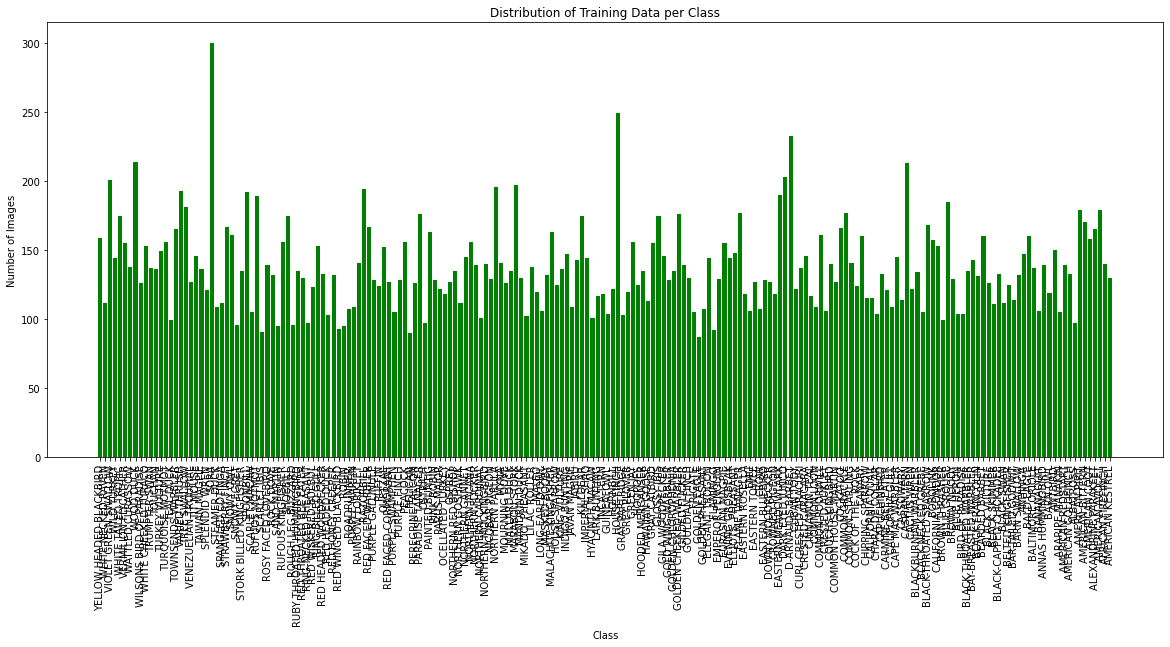

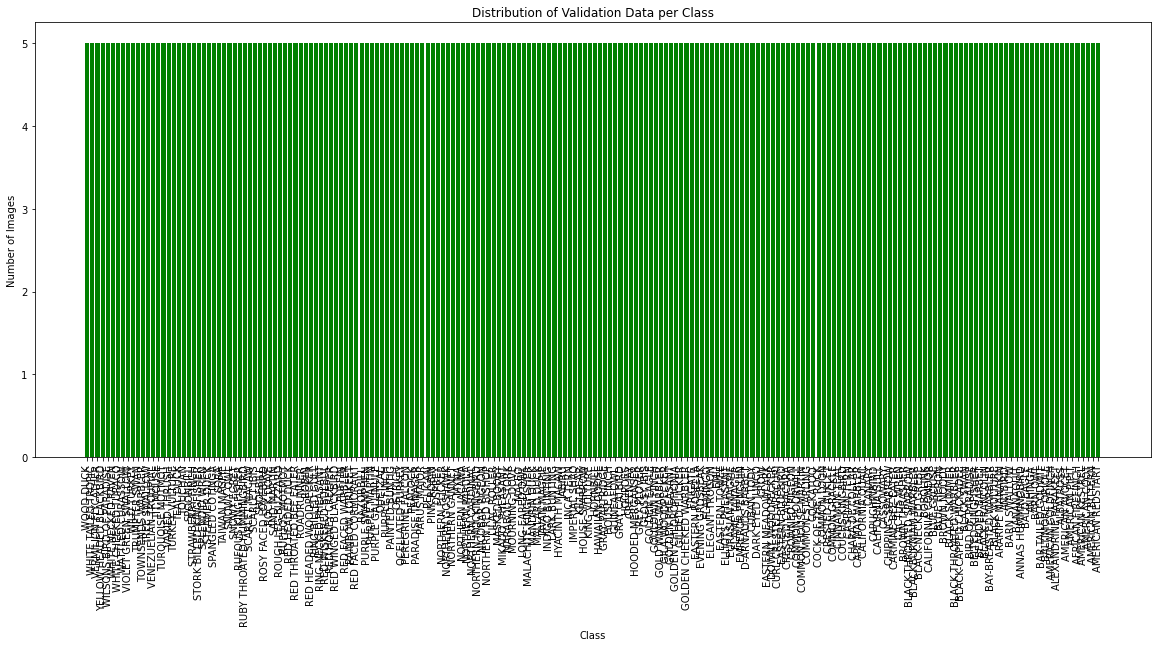

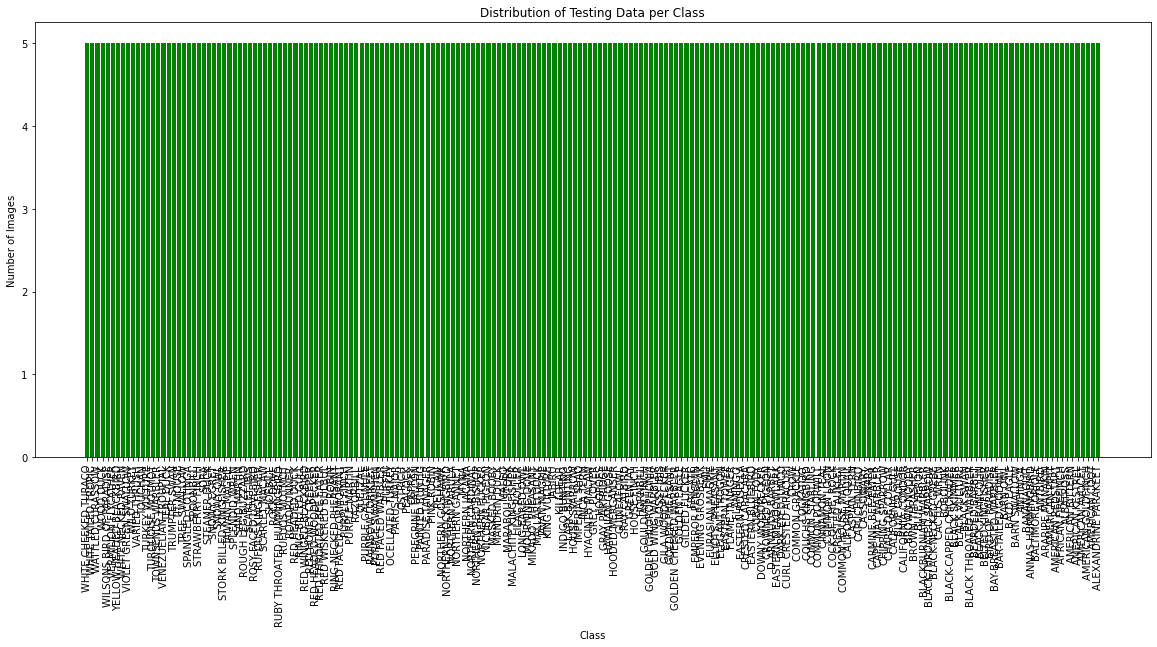

In [9]:
if presplit:
    plot_images_per_class(images_path, mode='train', title='Distribution of Training Data per Class')
    plot_images_per_class(images_path, mode='val', title='Distribution of Validation Data per Class')
    try:
        plot_images_per_class(images_path, mode='test', title='Distribution of Testing Data per Class')
    except:
        pass
else:
    plot_images_per_class(images_path, mode='', title='Distribution of All Images per Class')

In [10]:
net_model = resnet.resnet152(pretrained=True)
net_name = 'resnet152'
unfrozen_layers = ['fc']  # 'layer4', 
dropout_ratio = 0.2

net_model = load_network(net_model, net_name, dropout_ratio, class_names, unfrozen_layers)

print(f'Images in training set {len(training_set)}, validation set {len(validation_set)}, testing set {len(testing_set)}')

Downloading: "https://download.pytorch.org/models/resnet152-b121ed2d.pth" to /root/.cache/torch/checkpoints/resnet152-b121ed2d.pth



conv1 is frozen
bn1 is frozen
relu is frozen
maxpool is frozen
layer1 is frozen
layer2 is frozen
layer3 is frozen
layer4 is frozen
avgpool is frozen
fc is unfrozen


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

58,719,752 total parameters
575,944 training parameters
Images in training set 27503, validation set 1000, testing set 1000


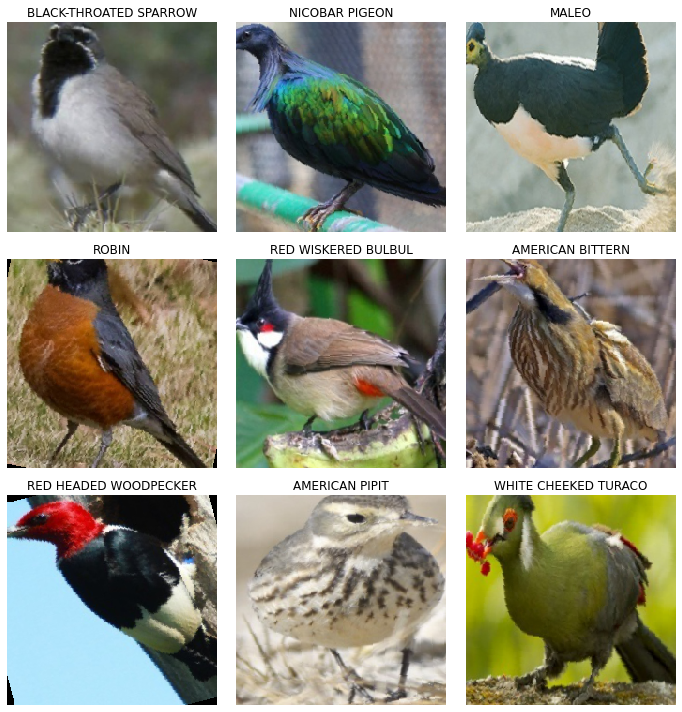

In [11]:
plot_grid_images(training_set, batch_size, class_names, mean, std, rows=3, columns=3, size=10)

In [12]:
learning_rate = 0.0003
epochs = 100
momentum = 0.9
weight_decay = 0
patience = 3
n_epochs_stop = 5

net_model, loss_acc, y_testing, preds = train_model(results_path, net_name, net_model, training_set_loader, validation_set_loader, 
                                                    learning_rate, epochs, momentum, weight_decay, patience, n_epochs_stop)

Using 1 GPUs
[train] Epoch 1/100 Iteration 1/215 Loss: 5.30 Accuracy: 0.00
[train] Epoch 1/100 Iteration 44/215 Loss: 5.13 Accuracy: 0.05
[train] Epoch 1/100 Iteration 87/215 Loss: 4.89 Accuracy: 0.10
[train] Epoch 1/100 Iteration 130/215 Loss: 4.61 Accuracy: 0.14
[train] Epoch 1/100 Iteration 173/215 Loss: 4.32 Accuracy: 0.19
[train] Epoch 1/100 Iteration 215/215 Loss: 4.05 Accuracy: 0.23
[val] Epoch 1/100 Iteration 1/8 Loss: 2.47 Accuracy: 0.61
[val] Epoch 1/100 Iteration 2/8 Loss: 2.58 Accuracy: 0.60
[val] Epoch 1/100 Iteration 3/8 Loss: 2.58 Accuracy: 0.60
[val] Epoch 1/100 Iteration 4/8 Loss: 2.59 Accuracy: 0.59
[val] Epoch 1/100 Iteration 5/8 Loss: 2.55 Accuracy: 0.58
[val] Epoch 1/100 Iteration 6/8 Loss: 2.52 Accuracy: 0.60
[val] Epoch 1/100 Iteration 7/8 Loss: 2.50 Accuracy: 0.59
[val] Epoch 1/100 Iteration 8/8 Loss: 2.51 Accuracy: 0.58
[val] Epoch 1/100 Iteration 8/8 Loss: 2.51 Accuracy: 0.58
[train] Epoch 2/100 Iteration 1/215 Loss: 2.71 Accuracy: 0.41
[train] Epoch 2/100 Ite

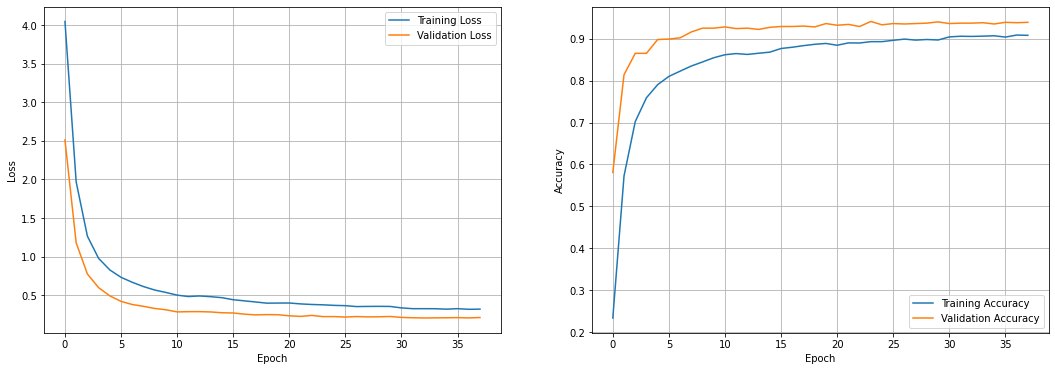

In [13]:
plot_logs_classification(results_path, net_name, loss_acc)

In [14]:
preds_test, y_true = test_model(net_name, net_model, testing_set_loader)

Iteration 1/8
Iteration 2/8
Iteration 3/8
Iteration 4/8
Iteration 5/8
Iteration 6/8
Iteration 7/8
Iteration 8/8


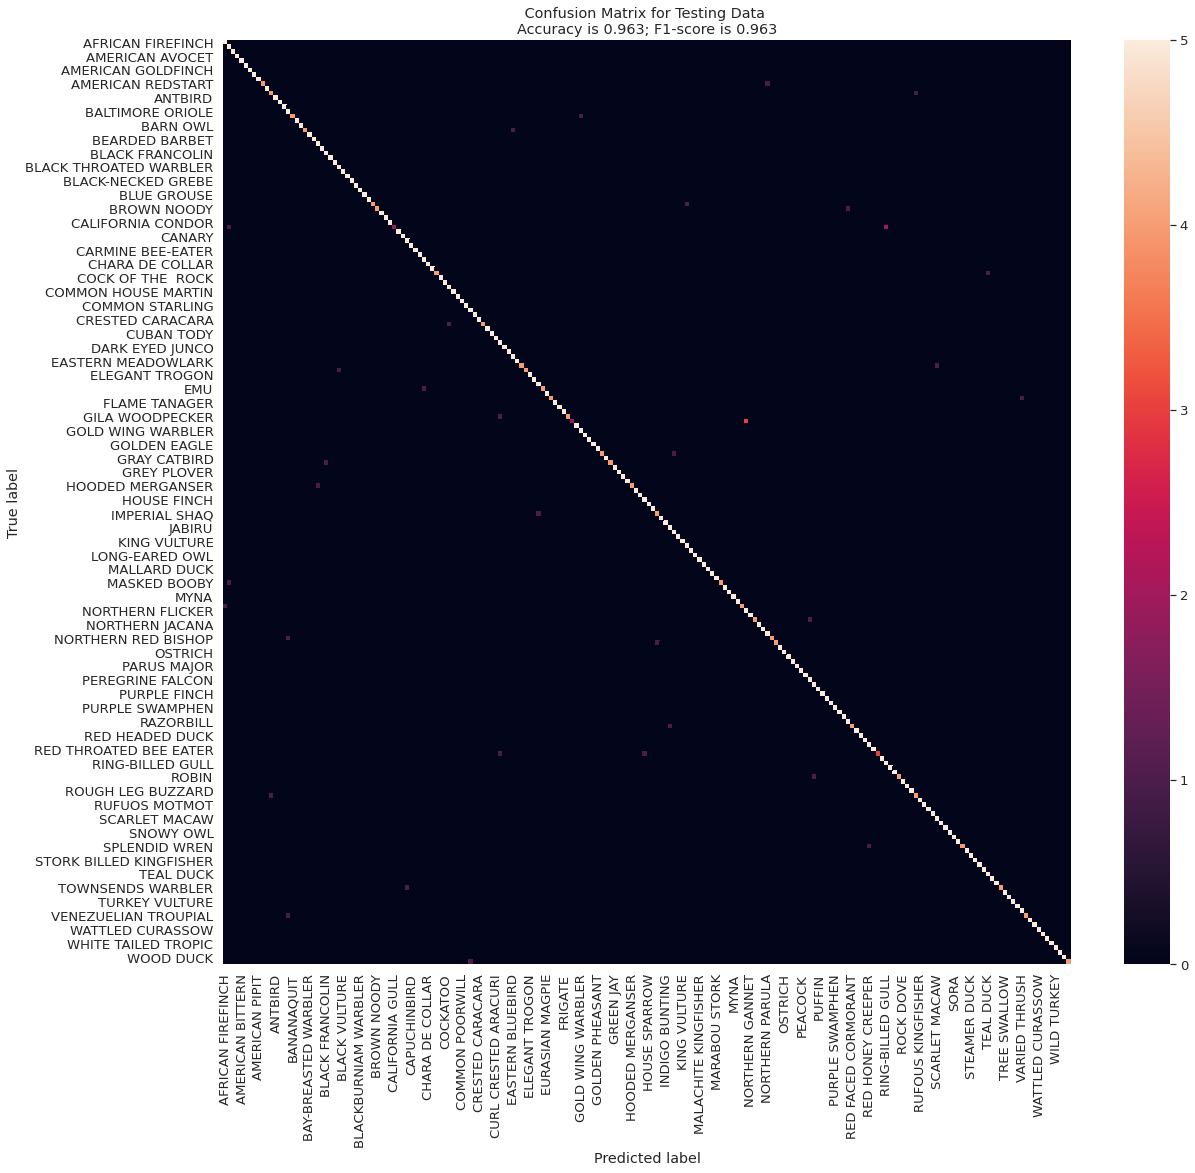

In [15]:
display_confusion_matrix(results_path, net_name, y_true, preds_test, class_names, annot=False, figsize=(19,17), fontsize=8)

In [16]:
print(classification_report(y_true, preds_test.argmax(1), target_names=class_names))

                           precision    recall  f1-score   support

        AFRICAN FIREFINCH       0.83      1.00      0.91         5
                ALBATROSS       0.71      1.00      0.83         5
     ALEXANDRINE PARAKEET       1.00      1.00      1.00         5
          AMERICAN AVOCET       1.00      1.00      1.00         5
         AMERICAN BITTERN       1.00      1.00      1.00         5
            AMERICAN COOT       1.00      1.00      1.00         5
       AMERICAN GOLDFINCH       1.00      1.00      1.00         5
         AMERICAN KESTREL       1.00      1.00      1.00         5
           AMERICAN PIPIT       1.00      1.00      1.00         5
        AMERICAN REDSTART       1.00      0.80      0.89         5
                  ANHINGA       1.00      1.00      1.00         5
        ANNAS HUMMINGBIRD       0.80      0.80      0.80         5
                  ANTBIRD       1.00      1.00      1.00         5
          ARARIPE MANAKIN       1.00      1.00      1.00     

In [17]:
# class CustomTrainIter(TrainDataLoaderIter):
#     def inputs_labels_from_batch(self, batch_data):
#         return batch_data["image"], batch_data["label"]
    
# custom_train_iter = CustomTrainIter(training_set_loader)

# criterion = nn.CrossEntropyLoss()
# # optimizer = Adam(net_model.parameters(), lr=1e-5, weight_decay=1e-2)
# optimizer = SGD(net_model.parameters(), lr=1e-5, momentum=momentum, weight_decay=weight_decay)

# # No lr_scheduler
# # Look for the lr where the curve has the greatest decline or steepest downward slope

# lr_finder = LRFinder(net_model, optimizer, criterion, device='cpu')
# lr_finder.reset()
# lr_finder.range_test(custom_train_iter, end_lr=100, num_iter=100, step_mode="exp")
# lr_finder.plot() # to inspect the loss-learning rate graph
# lr_finder.reset()

In [18]:
# class CustomValIter(ValDataLoaderIter):
#     def inputs_labels_from_batch(self, batch_data):
#         return batch_data["image"], batch_data["label"]

# custom_val_iter = CustomValIter(validation_set_loader)
# lr_finder.reset()
# lr_finder.range_test(custom_train_iter, val_loader=custom_val_iter, end_lr=100, num_iter=100, step_mode="exp")
# lr_finder.plot() # to inspect the loss-learning rate graph
# lr_finder.reset()